## How to travel between N Russian cities and return to the starting point using the shortest route? Let's find out!

## 2-opt is a simple local search algorithm first proposed by Croes in 1958 for solving the traveling salesman problem. The main idea behind it is to take a route that crosses over itself and reorder it so that it does not. 
### It is very easy to implement and result visualization is cool.

In [322]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from math import sin, cos, atan2, sqrt, radians

%matplotlib inline

In [7]:
# download russian towns dataset from GeoNames Data - it is free and has data for every country!
from urllib.request import urlretrieve
urlretrieve ("http://download.geonames.org/export/dump/RU.zip", "./data/RU.zip")

('./data/RU.zip', <http.client.HTTPMessage at 0x7fca2c402240>)

In [11]:
from zipfile import ZipFile
with ZipFile("./data/RU.zip","r") as zip_ref:
    zip_ref.extractall("./data/RU")

In [345]:
towns = pd.read_csv("./data/RU/RU.txt", sep='\t', index_col='name', names=['name', 'latitude', 'longitude', 'feature_class', 'feature_code', 'population', ], 
                    usecols=[1,4,5,6,7,14])
towns.head(3)
# here are some unknown small villages, get rid of them!

,latitude,longitude,feature_class,feature_code,population
name,,,,,
Zyabrikovo,56.84665,34.70480,P,PPL,0
Znamenka,56.74087,34.02323,P,PPL,0
Zhukovo,57.26429,34.20956,P,PPL,0


In [348]:
N = 20
towns = towns[towns.feature_code == 'PPLA'] # leave only first-order administrative cities
towns = towns[towns.population > 500000]
towns = towns.sample(N)
towns

,latitude,longitude,feature_class,feature_code,population
name,,,,,
Irkutsk,52.29778,104.29639,P,PPLA,586695
Kazan,55.78874,49.12214,P,PPLA,1104738
Yekaterinburg,56.85190,60.61220,P,PPLA,1349772
Tyumen,57.15222,65.52722,P,PPLA,519119
Penza,53.20066,45.00464,P,PPLA,512602
Ryazan’,54.62690,39.69160,P,PPLA,520173
Yaroslavl,57.62987,39.87368,P,PPLA,606730
Krasnoyarsk,56.01839,92.86717,P,PPLA,927200
Khabarovsk,48.48271,135.08379,P,PPLA,579000


In [325]:
def make_russian_map():
    llcrnrlat, llcrnrlon = 41, 23
    urcrnrlat, urcrnrlon = 80, 170

    map = Basemap(projection='mill',llcrnrlat=llcrnrlat,urcrnrlat=urcrnrlat,\
                llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, resolution='c')

    map.drawcoastlines()
    map.drawcountries()
    map.drawstates()
    map.fillcontinents(color='#04BAE3', lake_color='#FFFFFF')
    map.drawmapboundary(fill_color='#FFFFFF')
    
    return map

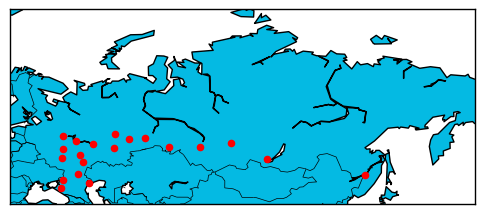

In [352]:
map = make_russian_map()

lons = towns.longitude.values
lats = towns.latitude.values
x, y = map(lons, lats)

map.scatter(x, y, marker='o',color='r', zorder=10)
plt.show()

In [288]:
# compute NxN distance matrix. Can't use simple euclidean distance, do some math magic:
distances = np.zeros((N, N))
R = 6373 # Earth radius in kilometers
for i in range(N):
    for j in range(N):
        lat1, lon1 = towns.iloc[i][['latitude', 'longitude']]
        lat2, lon2 = towns.iloc[j][['latitude', 'longitude']]
        lat1, lon1, lat2, lon2 = radians(lat1), radians(lon1), radians(lat2), radians(lon2)
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = (sin(dlat / 2)) ** 2 + cos(lat1) * cos(lat2) * (sin(dlon / 2)) ** 2 
        c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
        d = R * c
        
        distances[i, j] = distances[j, i] = d

In [289]:
distances = pd.DataFrame(data=distances, index=towns.index.values, columns=towns.index.values)

In [290]:
distances

,Penza,Orenburg,Yaroslavl,Izhevsk,Astrakhan,Ryazan’,Vladivostok,Perm,Krasnoyarsk,Krasnodar,Omsk,Novosibirsk,Ufa,Ulyanovsk,Saratov,Yekaterinburg,Voronezh,Volgograd,Kazan,Lipetsk
Penza,0.000000,701.266483,589.261836,661.139522,792.436680,382.399462,6137.130847,884.429863,3036.667862,1006.881382,1847.907865,2450.487912,736.642608,255.251334,196.832993,1071.749423,429.582786,499.690608,391.813304,370.482339
Orenburg,701.266483,0.000000,1171.518717,577.884631,792.022122,1072.001212,5583.267246,697.696261,2487.348536,1401.456341,1259.746764,1868.041702,335.407007,530.899357,627.383323,668.227801,1094.449021,825.732102,594.417544,1060.835997
Yaroslavl,589.261836,1171.518717,0.000000,805.722887,1371.450537,334.210183,6195.565338,968.661338,3147.795164,1401.187992,2065.544171,2625.302098,1043.745515,643.885112,783.583721,1246.294464,664.162411,1037.425954,600.048195,559.456108
Izhevsk,661.139522,577.884631,805.722887,0.000000,1220.331175,879.884055,5496.507122,223.409495,2406.642066,1641.855862,1268.799802,1847.833678,291.089470,412.593219,752.826804,450.338076,1074.621814,1075.454018,278.040564,992.555460
Astrakhan,792.436680,792.022122,1371.450537,1220.331175,0.000000,1092.289021,6310.066376,1410.305918,3238.759251,718.594382,2011.940526,2608.317910,1087.279567,887.790446,596.097021,1450.826733,875.217502,374.227346,1052.587690,925.337212
Ryazan’,382.399462,1072.001212,334.210183,879.884055,1092.289021,0.000000,6366.894853,1085.153108,3284.912298,1067.031493,2138.162107,2726.033561,1044.270482,562.549227,543.672292,1327.669923,330.403736,735.701746,611.811047,225.246893
Vladivostok,6137.130847,5583.267246,6195.565338,5496.507122,6310.066376,6366.894853,0.000000,5283.237256,3103.621861,6982.350617,4323.960739,3715.231592,5411.565826,5882.345035,6162.190508,5065.613598,6564.160158,6408.448042,5773.927639,6487.738786
Perm,884.429863,697.696261,968.661338,223.409495,1410.305918,1085.153108,5283.237256,0.000000,2200.904687,1861.985454,1099.703856,1658.513099,363.847393,635.608781,972.429480,291.170194,1295.149335,1290.777117,498.179664,1210.582264
Krasnoyarsk,3036.667862,2487.348536,3147.795164,2406.642066,3238.759251,3284.912298,3103.621861,2200.904687,0.000000,3888.804659,1229.416374,634.079864,2308.199036,2782.655234,3058.590556,1967.315286,3465.139608,3309.893497,2681.757476,3392.209730
Krasnodar,1006.881382,1401.456341,1401.187992,1641.855862,718.594382,1067.031493,6982.350617,1861.985454,3888.804659,0.000000,2660.693781,3267.767055,1619.007624,1232.500701,889.557594,1990.448052,737.302191,585.831037,1391.496159,841.824419


In [354]:
# generate random Hamiltonian cycle for towns (graph cycle that visits each node exactly once)
path = np.random.permutation(towns.index.values)
path = np.append(path, path[0])
path

array(['Krasnoyarsk', 'Yaroslavl', 'Astrakhan', 'Perm', 'Kazan',
       'Krasnodar', 'Ryazan’', 'Saratov', 'Novosibirsk', 'Lipetsk',
       'Volgograd', 'Irkutsk', 'Nizhniy Novgorod', 'Omsk', 'Ufa',
       'Khabarovsk', 'Tyumen', 'Rostov-na-Donu', 'Yekaterinburg', 'Penza',
       'Krasnoyarsk'], dtype=object)

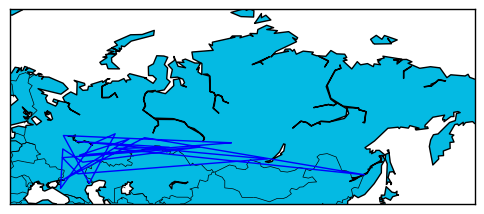

In [355]:
# draw this random path
map = make_russian_map()

lons, lats = [], []
for city in path:
    lat, lon = towns.loc[city][['latitude', 'longitude']]
    lats.append(lat)
    lons.append(lon)

lines = map.plot(lons, lats, latlon=True, zorder=10)

plt.show()

In [335]:
def swap(path, m, n):
    assert m < n
    path[m : n+1] = path[m : n+1][::-1]

def optimize_step():
    improve = True
    while improve:
        improve = False
        for i in range(1, len(path)-1):
            for j in range(i+1, len(path)-1):
                cityA, cityB = path[i-1], path[i]
                cityC, cityD = path[j], path[j+1]
                old_distance = distances.loc[cityA, cityB] + distances.loc[cityC, cityD]
                new_distance = distances.loc[cityA, cityC] + distances.loc[cityB, cityD]

                if new_distance < old_distance:
                    swap(path, i, j)
                    improve = True
                    yield path

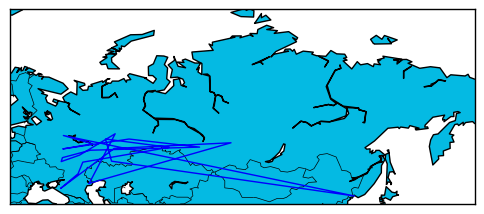

In [343]:
map = make_russian_map()

lats, lons = [], []
for city in path:
    lat, lon = towns.loc[city][['latitude', 'longitude']]
    lats.append(lat)
    lons.append(lon)

lons, lats = map(lons, lats)
lines, = map.plot(lons, lats, latlon=False, zorder=10)

# animation function.  This is called sequentially
def animate(new_path):    
    lats, lons = [], []
    for city in new_path:
        lat, lon = towns.loc[city][['latitude', 'longitude']]
        lats.append(lat)
        lons.append(lon)
    lons,lats = map(lons, lats)
    lines.set_data(lons, lats)
    return lines,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(plt.gcf(), animate, frames=optimize_step, interval=500, blit=True)

In [344]:
HTML(anim.to_html5_video())